In [122]:
import config as c
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys

# Descriptive Analysis
- demographic data
- fitts' law
    - effective id
    - task completion time (overall & per id)
    - error rate (overall & per id)
    - throughput (overall & per id)
    - regression of error rate
    - regression of task completion time
- nasa-tlx

## Analysis of Demographic Data

In [49]:
demographic_df = pd.DataFrame()
for id in range(c.NUM_PARTICIPANTS):
    demographic_raw = pd.read_csv(
        c.FOLDER_PATH
        + str(id + 1)
        + f"/demographic_participant_{id + 1}.csv"
    )
    demographic_df = pd.concat([demographic_df, demographic_raw])

demographic_df.head()

,participant_id,agreed,age,gender,hand,input_device,mouse,constraints
0,1,True,23,male,right,Mouse,often,NaN
0,2,True,26,female,right,Touchpad,never,NaN
0,3,True,25,male,right,Mouse,often,NaN
0,4,True,24,male,right,Mouse,often,NaN
0,5,True,24,female,right,Touchpad,never,NaN


In [50]:
mean_age = np.mean(demographic_df["age"])
std_age = np.std(demographic_df["age"])
print("Average age: ", mean_age, " (Std: ", std_age, ")")
print(
    "Gender: \n",
    demographic_df["gender"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)
print(
    "Handedness: \n",
    demographic_df["hand"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)
print(
    "Most used input device: \n",
    demographic_df["input_device"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)
print(
    "Frequency of mouse input: \n",
    demographic_df["mouse"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)

Average age:  26.75  (Std:  3.992179855667828 )
Gender: 
    gender  count
0    male      6
1  female      2
Handedness: 
     hand  count
0  right      8
Most used input device: 
   input_device  count
0        Mouse      4
1     Touchpad      2
2        often      2
Frequency of mouse input: 
    mouse  count
0  often      4
1  never      2


## Analyis of Fitts' Law 

In [51]:
latency_conditions = [-40, -20, 0, 20, 40]
balanced_latin_square = [[0,1,4,3,2],
                        [4,2,0,3,1],
                        [3,2,1,4,0],
                        [1,0,3,4,2],
                        [4,0,2,1,3],
                        [2,3,4,1,0],
                        [1,3,0,2,4],
                        [0,4,1,2,3],
                        [2,4,3,0,1],
                        [3,1,2,0,4]]

clicks_df = pd.DataFrame()
for id in range(c.NUM_PARTICIPANTS):
    for trial in range(c.NUM_TRIALS):
        clicks_raw = pd.read_csv(
            c.FOLDER_PATH
            + str(id + 1)
            + f"/clicks_participant_{id + 1}_trial_{trial}.csv"
        )
        clicks_raw["level_of_latency"] = latency_conditions[balanced_latin_square[id][trial]]
        clicks_df = pd.concat([clicks_df, clicks_raw])
    
clicks_df.head()

,id,timestamp_ms,participant_id,trial,level_of_latency,target_number,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,0,1710166191603,1,0,-40,0,30,450,959,103,957,107,1,1.787344
1,1,1710166193111,1,0,-40,1,30,450,1113,975,1117,968,1,1.508388
2,2,1710166194311,1,0,-40,2,30,450,670,208,672,211,1,1.199971
3,3,1710166196228,1,0,-40,3,30,450,1349,778,1353,787,1,1.916836
4,4,1710166197495,1,0,-40,4,30,450,516,474,519,467,1,1.267135


In [52]:
# drop irrelevant columns
clicks_df = clicks_df.drop(
    ["timestamp_ms", "target_number"], axis=1
)
# drop rows of first click in round (no fitts law task)
clicks_df = clicks_df.drop(clicks_df.loc[clicks_df["id"] % 9 == 0].index, axis=0)
clicks_df.reset_index(inplace=True, drop=True)
clicks_df

,id,participant_id,trial,level_of_latency,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,1,1,0,-40,30,450,1113,975,1117,968,1,1.508388
1,2,1,0,-40,30,450,670,208,672,211,1,1.199971
2,3,1,0,-40,30,450,1349,778,1353,787,1,1.916836
3,4,1,0,-40,30,450,516,474,519,467,1,1.267135
4,5,1,0,-40,30,450,1403,474,1409,482,1,1.045496
...,...,...,...,...,...,...,...,...,...,...,...,...
11515,319,8,4,20,200,325,639,496,674,538,1,0.374598
11516,320,8,4,20,200,325,1280,496,1278,518,1,0.345631
11517,321,8,4,20,200,325,678,715,666,708,1,0.375143
11518,322,8,4,20,200,325,1168,304,1189,310,1,0.433668


In [53]:
# drop rows with unsuccessful fitts law tasks
error_indices = clicks_df.loc[clicks_df["success"]==0].index
task_after_error_indices = clicks_df.loc[clicks_df["success"]==0].index + 1
clicks_error_df = clicks_df.drop(error_indices, axis=0)
clicks_error_df = clicks_df.drop(task_after_error_indices, axis=0)

clicks_error_df.reset_index(inplace=True, drop=True)
clicks_error_df

,id,participant_id,trial,level_of_latency,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,1,1,0,-40,30,450,1113,975,1117,968,1,1.508388
1,2,1,0,-40,30,450,670,208,672,211,1,1.199971
2,3,1,0,-40,30,450,1349,778,1353,787,1,1.916836
3,4,1,0,-40,30,450,516,474,519,467,1,1.267135
4,5,1,0,-40,30,450,1403,474,1409,482,1,1.045496
...,...,...,...,...,...,...,...,...,...,...,...,...
10955,319,8,4,20,200,325,639,496,674,538,1,0.374598
10956,320,8,4,20,200,325,1280,496,1278,518,1,0.345631
10957,321,8,4,20,200,325,678,715,666,708,1,0.375143
10958,322,8,4,20,200,325,1168,304,1189,310,1,0.433668


### Overall Fitts' Law Analysis
- Calculation of id
- Calculation of effective id
- Mean error rate
- Mean completion time
- Mean throughput

In [54]:
# calculation of id
clicks_df["ID"] = np.log2(clicks_df["target_amplitude"] / clicks_df["target_width"] + 1)
clicks_error_df["ID"] = np.log2(clicks_error_df["target_amplitude"] / clicks_error_df["target_width"] + 1)

In [55]:
# calculation of effective id
num_ids = len(clicks_df["ID"].unique())

clicks_df["distance_from_target"] = np.sqrt(
    (clicks_df["target_x"] - clicks_df["cursor_x"])**2 +
    (clicks_df["target_y"] - clicks_df["cursor_y"])**2
)

effective_id_df = pd.DataFrame({"ID": clicks_df["ID"].unique(), 
                                "sigma": np.zeros(num_ids),
                                "amplitude": np.zeros(num_ids),
                                "width": np.zeros(num_ids)})
for _, entry in clicks_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            row["amplitude"] = entry["target_amplitude"]
            row["width"] = entry["target_width"]
            row["sigma"] += entry["distance_from_target"]

effective_id_df["sigma"] /= len(clicks_df)/9
effective_id_df["We"] = 4.133 * effective_id_df["sigma"]
effective_id_df["IDe"] = np.log2(
    effective_id_df["amplitude"] / effective_id_df["We"] + 1
)
effective_id_df.sort_values(by=["ID"])

,ID,sigma,amplitude,width,We,IDe
5,1.000000,31.232823,200.0,200.0,129.085255,1.350137
3,1.392317,44.616884,325.0,200.0,184.401581,1.465952
8,1.415037,25.413204,200.0,120.0,105.032773,1.538125
6,1.700440,46.575299,450.0,200.0,192.495710,1.738861
2,1.890771,29.890679,325.0,120.0,123.538177,1.860274
7,2.247928,27.239121,450.0,120.0,112.579288,2.321115
4,2.938599,8.726815,200.0,30.0,36.067925,2.710414
1,3.564785,8.713079,325.0,30.0,36.011154,3.325528
0,4.000000,9.336719,450.0,30.0,38.588661,3.662371


In [56]:
def calculate_mean_std(arr):
    return round(np.mean(arr), 2), round(np.std(arr), 2)

In [57]:
# calculation of mean and standard deviation of error rate and completion time
print("Mean error rate: ",  calculate_mean_std(1 - clicks_df["success"]))
print("Mean completion time: ",  calculate_mean_std(clicks_df["completion_time"]))

Mean error rate:  (0.05, 0.22)
Mean completion time:  (0.65, 0.26)


In [134]:
# calculation of throughput
throughput_df = pd.DataFrame({"IDe": np.zeros(clicks_error_df.shape[0]),
                              "completion_time": clicks_error_df["completion_time"],
                              "level_of_latency": clicks_error_df["level_of_latency"],
                              "participant_id": clicks_error_df["participant_id"]})

for index, entry in clicks_error_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            throughput_df.loc[index,"IDe"] = row["IDe"]

throughput_df["throughput"] = throughput_df["IDe"] / throughput_df["completion_time"]
print("Mean throughput: ",  calculate_mean_std(throughput_df["throughput"]))

Mean throughput:  (3.59, 0.96)


In [85]:
error_df = pd.DataFrame({"IDe": np.zeros(clicks_df.shape[0]),
                        "error_rate": 1 - clicks_df["success"],
                        "level_of_latency": clicks_df["level_of_latency"],
                        "participant_id": clicks_df["participant_id"]})

for index, entry in clicks_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            error_df.loc[index,"IDe"] = row["IDe"]
error_df.head()

,IDe,error_rate,level_of_latency,participant_id
0,3.662371,0,-40,1
1,3.662371,0,-40,1
2,3.662371,0,-40,1
3,3.662371,0,-40,1
4,3.662371,0,-40,1


In [60]:
# calculation of throughput, error rate, completion time per id
ides = throughput_df["IDe"].unique()
throughput_df_per_id = pd.DataFrame({"IDe": ides,
                                     "mean_throughput": np.zeros(len(ides)),
                                     "std_throughput": np.zeros(len(ides)),
                                     "mean_completion_time": np.zeros(len(ides)),
                                     "std_completion_time": np.zeros(len(ides))})
error_df_per_id = pd.DataFrame({"IDe": ides,
                                "mean_error_rate": np.zeros(len(ides)),
                                "std_error_rate": np.zeros(len(ides))})

for _, entry in throughput_df_per_id.iterrows():
    id = entry["IDe"]
    queried_df = throughput_df.query(f"IDe=={id}")
    throughput = queried_df["throughput"]
    completion_time = queried_df["completion_time"]
    entry["mean_throughput"], entry["std_throughput"] = calculate_mean_std(throughput)
    entry["mean_completion_time"], entry["std_completion_time"] = calculate_mean_std(completion_time)

for _, entry in error_df_per_id.iterrows():
    id = entry["IDe"]
    queried_df = error_df.query(f"IDe=={id}")
    error_rate = queried_df["error_rate"]
    entry["mean_error_rate"], entry["std_error_rate"] = calculate_mean_std(error_rate)

throughput_df_per_id["IDe"] = round(throughput_df_per_id["IDe"], 2)
error_df_per_id["IDe"] = round(error_df_per_id["IDe"], 2)
throughput_df_per_id = throughput_df_per_id.sort_values(by=["IDe"])
throughput_df_per_id

,IDe,mean_throughput,std_throughput,mean_completion_time,std_completion_time
5,1.35,3.35,1.08,0.44,0.15
3,1.47,3.38,0.97,0.47,0.13
8,1.54,3.58,1.09,0.46,0.13
6,1.74,3.31,0.86,0.56,0.16
2,1.86,3.47,0.90,0.57,0.15
7,2.32,3.72,0.83,0.65,0.14
4,2.71,3.67,0.89,0.79,0.21
1,3.33,3.96,0.90,0.89,0.22
0,3.66,3.90,0.87,0.99,0.24


In [61]:
error_df_per_id

,IDe,mean_error_rate,std_error_rate
0,3.66,0.11,0.32
1,3.33,0.07,0.26
2,1.86,0.04,0.19
3,1.47,0.03,0.17
4,2.71,0.08,0.27
5,1.35,0.01,0.07
6,1.74,0.04,0.20
7,2.32,0.04,0.19
8,1.54,0.02,0.15


In [67]:
throughput_df.groupby(["level_of_latency"]).mean()

,IDe,completion_time,throughput
level_of_latency,,,
-40,2.196749,0.700404,3.294873
-20,2.196759,0.650653,3.498667
0,2.199054,0.613258,3.792305
20,2.202291,0.603592,3.764818
40,2.193634,0.645436,3.578969


In [ ]:
throughput_df.groupby(["level_of_latency"]).std()

,IDe,completion_time,throughput
level_of_latency,,,
-40,0.804913,0.241458,0.931423
-20,0.783003,0.252555,0.851469
0,0.760011,0.265689,0.808001
20,0.794455,0.239419,0.967317
40,0.796058,0.269961,1.152188


In [68]:
error_mean_df = error_df.groupby(["level_of_latency"], as_index=False).mean()
error_mean_df

,level_of_latency,IDe,error_rate
0,-40,2.219197,0.063368
1,-20,2.219197,0.039931
2,0,2.219197,0.049045
3,20,2.219197,0.042101
4,40,2.219197,0.048611


In [69]:
error_std_df = error_df.groupby(["level_of_latency"], as_index=False).std()
error_std_df

,level_of_latency,IDe,error_rate
0,-40,0.796306,0.243677
1,-20,0.796306,0.195839
2,0,0.796306,0.216009
3,20,0.796306,0.200862
4,40,0.796306,0.215100


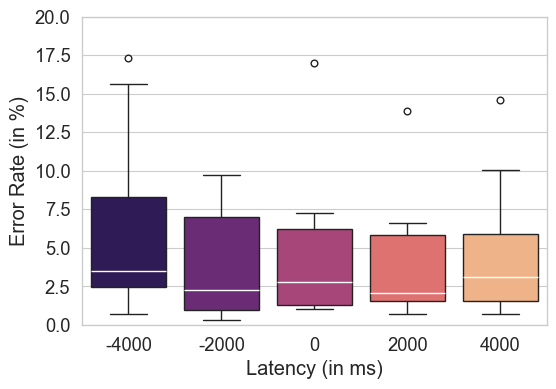

In [132]:
sns.set_theme(style="whitegrid", font_scale=1.5, context="paper")
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)
fig2 = plt.figure(figsize=(6, 4))
ax = plt.gca()

p = sns.boxplot(
    data=error_df.groupby(
        ["participant_id", "level_of_latency"], as_index=False
    ).mean()*100,
    x="level_of_latency",
    y="error_rate",
    hue="level_of_latency",
    palette=palette,
    showfliers=True,
    medianprops={"color": "white", "label": "_median_"},
)
# sns.swarmplot(
#     data=error_df.groupby(
#         ["participant_id", "level_of_latency"], as_index=False
#     ).mean()*100,
#     x="level_of_latency",
#     y="error_rate",
#     palette=palette,
#     edgecolor="black",
#     linewidth=0.5,
#     alpha=0.5,
#     dodge=True,
#     legend=False,
# )


ax.set_xlabel("Latency (in ms)")
ax.set_ylabel("Error Rate (in %)")

ax.get_legend().set_visible(False)
ax.set_ylim(0, 20)
plt.savefig('figures/boxplot_error_rate.pdf', bbox_inches='tight')

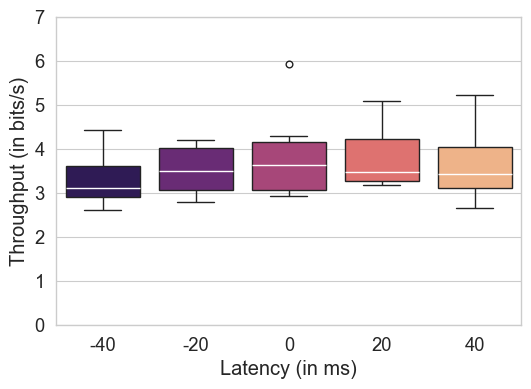

In [137]:
sns.set_theme(style="whitegrid", font_scale=1.5, context="paper")
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)
fig2 = plt.figure(figsize=(6, 4))
ax = plt.gca()

p = sns.boxplot(
    data=throughput_df.groupby(
        ["participant_id", "level_of_latency"], as_index=False
    ).mean(),
    x="level_of_latency",
    y="throughput",
    hue="level_of_latency",
    palette=palette,
    showfliers=True,
    medianprops={"color": "white", "label": "_median_"},
)
# sns.swarmplot(
#     data=error_df.groupby(
#         ["participant_id", "level_of_latency"], as_index=False
#     ).mean()*100,
#     x="level_of_latency",
#     y="error_rate",
#     palette=palette,
#     edgecolor="black",
#     linewidth=0.5,
#     alpha=0.5,
#     dodge=True,
#     legend=False,
# )


ax.set_xlabel("Latency (in ms)")
ax.set_ylabel("Throughput (in bits/s)")

ax.get_legend().set_visible(False)
ax.set_ylim(0, 7)
plt.savefig('figures/boxplot_throughput.pdf', bbox_inches='tight')

## Fitts' Law Regression
- Regression model for error rate
- Regression model for completion time

In [ ]:
def model_error_rate(x):
    slope_error_rate, intercept_error_rate, r_error_rate, p, std_err = stats.linregress(
        error_df_per_id["IDe"], error_df_per_id["mean_error_rate"]
    )
    return slope_error_rate * x + intercept_error_rate
slope_error_rate, intercept_error_rate, r_error_rate, p_error, std_err = stats.linregress(
        error_df_per_id["IDe"], error_df_per_id["mean_error_rate"]
    )
p_error

0.00020709104885018482

In [ ]:
def model_completion_time(x):
  slope_completion_time, intercept_completion_time, r_completion_time, p, std_err = stats.linregress(
    throughput_df_per_id["IDe"], throughput_df_per_id["mean_completion_time"]
    )
  return slope_completion_time * x + intercept_completion_time
slope_completion_time, intercept_completion_time, r_completion_time, p_time, std_err = stats.linregress(
    throughput_df_per_id["IDe"], throughput_df_per_id["mean_completion_time"]
    )
p_error

0.00020709104885018482

In [ ]:
ide = effective_id_df["IDe"]
completion_time = throughput_df_per_id["mean_completion_time"]
e_completion_time = throughput_df_per_id["std_completion_time"] * 1.96 / np.sqrt(throughput_df_per_id.shape[1])
error_rate = error_df_per_id["mean_error_rate"]
e_error_rate = error_df_per_id["std_error_rate"] * 1.96 / np.sqrt(error_df_per_id.shape[1])

regr_completion_time = list(map(model_completion_time, ide))
regr_error_rate = list(map(model_error_rate, ide))

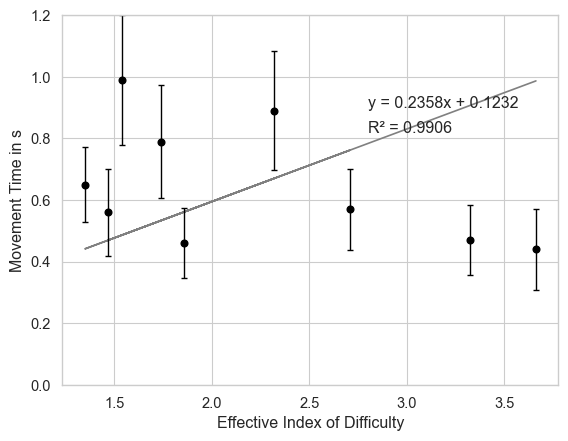

In [ ]:
# regression plot for completion time
sns.set_theme(style='whitegrid', font_scale=1.2, context='paper')

plt.plot(ide, regr_completion_time, color="grey")
plt.errorbar(ide, completion_time, e_completion_time, linestyle='None', capsize=2, fmt="o", color="black", elinewidth=1)
plt.xlabel("Effective Index of Difficulty")
plt.ylabel("Movement Time in s")

plt.ylim(0, 1.2)
plt.text(2.8, 0.82, 'R² = '+ str(round(r_completion_time**2, 4)))
plt.text(2.8, 0.9, 'y = '+ str(round(slope_completion_time, 4)) + "x + " + str(round(intercept_completion_time, 4)))
plt.savefig('figures/regression_completion_time.pdf', bbox_inches='tight')
plt.show()

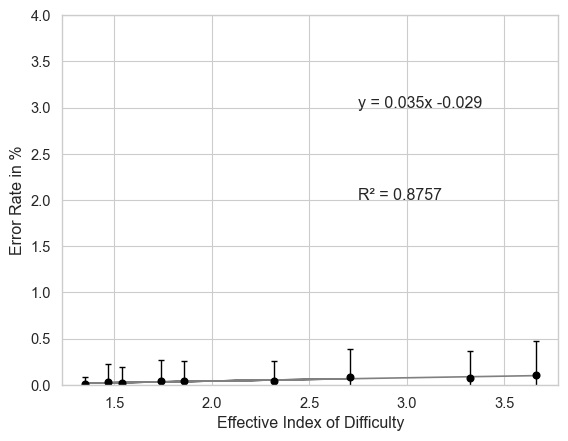

In [ ]:
# regression plot for error rate
sns.set_theme(style='whitegrid', font_scale=1.2, context='paper')

plt.plot(ide, regr_error_rate, color="grey")
plt.errorbar(ide, error_rate, e_error_rate, linestyle='None', capsize=2, fmt="o", color="black", elinewidth=1)
plt.xlabel("Effective Index of Difficulty")
plt.ylabel("Error Rate in %")

plt.ylim(0, 4)
plt.text(2.75, 2, 'R² = '+ str(round(r_error_rate**2, 4)))
plt.text(2.75, 3, 'y = '+ str(round(slope_error_rate, 3)) + "x " + str(round(intercept_error_rate, 3)))
plt.savefig('figures/regression_error_rate.pdf', bbox_inches='tight')
plt.show()

## NASA-TLX

In [ ]:
tlx_df = pd.DataFrame()
for id in range(c.NUM_PARTICIPANTS):
    tlx_raw = pd.read_csv(
        c.FOLDER_PATH
        + str(id + 1)
        + f"/tlx_participant_{id + 1}.csv"
    )
    tlx_raw["level_of_latency"] = balanced_latin_square[id]
    tlx_df = pd.concat([tlx_df, tlx_raw])

tlx_df.head()

,participant_id,trial,latency,mental_demand,physical_demand,temporal_demand,performance,effort,frustration,level_of_latency
0,1,0,0,8.0,10.0,16.2,2.0,13.0,4.8,0
1,1,1,0,14.0,10.8,14.2,8.4,12.2,11.2,1
2,1,2,0,16.4,15.8,8.6,12.2,14.0,8.6,4
3,1,3,0,10.8,13.0,4.6,6.6,11.0,4.0,3
4,1,4,0,8.2,8.2,12.2,6.2,7.0,4.4,2


In [ ]:
tlx_df.drop(["participant_id", "latency"], axis=1, inplace=True)

In [ ]:
# calculate overall scores
overall_tlx_df = tlx_df.drop(["trial"], axis=1)
for score in overall_tlx_df.columns:
    mean, std = calculate_mean_std(overall_tlx_df[score])
    print(score + ": " + str(mean) + " (" + str(std) + ")")

mean, std = calculate_mean_std(overall_tlx_df.to_numpy())
print("overall score: "+ str(mean) + " (" + str(std) + ")")

mental_demand: 7.28 (5.39)
physical_demand: 5.98 (4.88)
temporal_demand: 4.95 (4.57)
performance: 6.65 (4.15)
effort: 7.31 (4.43)
frustration: 7.08 (4.33)
level_of_latency: 2.0 (1.41)
overall score: 5.89 (4.68)


In [ ]:
# calculate scores per trial
trial = 0
trials = tlx_df["trial"].unique()
tlx_trial_df = pd.DataFrame(
    {
        "trial": trials,
        "mean_score": np.zeros(len(trials)),
        "mean_mental_demand": np.zeros(len(trials)),
        "mean_physical_demand": np.zeros(len(trials)),
        "mean_temporal_demand": np.zeros(len(trials)),
        "mean_performance": np.zeros(len(trials)),
        "mean_effort": np.zeros(len(trials)),
        "mean_frustration": np.zeros(len(trials)),
    }
)

tlx_std_trial_df = pd.DataFrame(
    {
        "trials": trials,
        "std_score": np.zeros(len(trials)),
        "std_mental_demand": np.zeros(len(trials)),
        "std_physical_demand": np.zeros(len(trials)),
        "std_temporal_demand": np.zeros(len(trials)),
        "std_performance": np.zeros(len(trials)),
        "std_effort": np.zeros(len(trials)),
        "std_frustration": np.zeros(len(trials)),
    }
)

for level_of_latency in tlx_df["level_of_latency"].unique():
    trial_df = tlx_df.query(f"level_of_latency=={level_of_latency}").drop(["level_of_latency"], axis=1)

    (
        tlx_trial_df.loc[trial, "mean_score"],
        tlx_std_trial_df.loc[trial, "std_score"],
    ) = calculate_mean_std(trial_df.to_numpy())


    (
        tlx_trial_df.loc[trial, "mean_mental_demand"],
        tlx_std_trial_df.loc[trial, "std_mental_demand"],
    ) = calculate_mean_std(trial_df["mental_demand"])

    (
        tlx_trial_df.loc[trial, "mean_physical_demand"],
        tlx_std_trial_df.loc[trial, "std_physical_demand"],
    ) = calculate_mean_std(trial_df["physical_demand"])

    (
        tlx_trial_df.loc[trial, "mean_temporal_demand"],
        tlx_std_trial_df.loc[trial, "std_temporal_demand"],
    ) = calculate_mean_std(trial_df["temporal_demand"])

    (
        tlx_trial_df.loc[trial, "mean_performance"],
        tlx_std_trial_df.loc[trial, "std_performance"],
    ) = calculate_mean_std(trial_df["performance"])

    (
        tlx_trial_df.loc[trial, "mean_effort"],
        tlx_std_trial_df.loc[trial, "std_effort"],
    ) = calculate_mean_std(trial_df["effort"])

    (
        tlx_trial_df.loc[trial, "mean_frustration"],
        tlx_std_trial_df.loc[trial, "std_frustration"],
    ) = calculate_mean_std(trial_df["frustration"])
    trial+=1

In [ ]:
tlx_trial_df

,trial,mean_score,mean_mental_demand,mean_physical_demand,mean_temporal_demand,mean_performance,mean_effort,mean_frustration
0,0,6.28,7.92,6.32,5.72,6.55,7.95,7.75
1,1,6.58,8.95,6.80,5.22,6.88,8.30,8.05
2,2,5.88,7.05,5.88,4.58,7.78,7.12,6.88
3,3,5.37,6.38,5.55,4.88,5.68,6.38,6.50
4,4,5.35,6.12,5.32,4.35,6.38,6.80,6.22


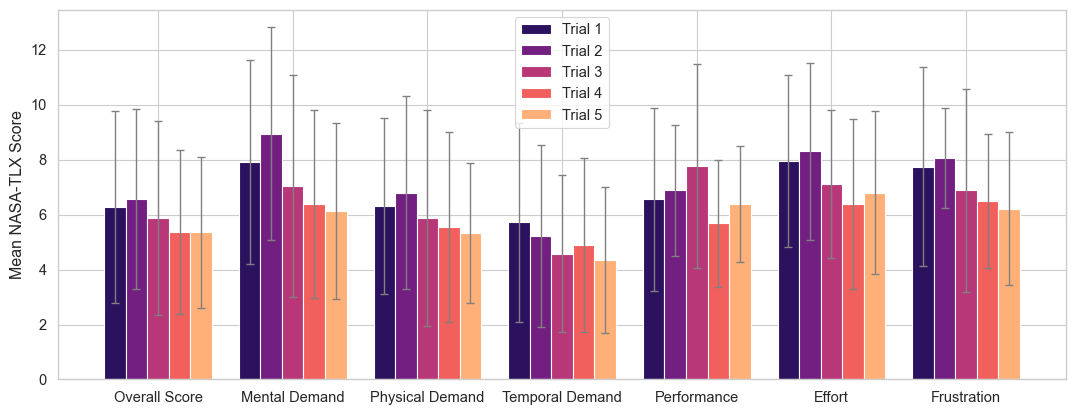

In [ ]:
scores = ("Overall Score", "Mental Demand", "Physical Demand", "Temporal Demand", "Performance", "Effort", "Frustration")
x = np.arange(1, len(scores) + 1, 1)
sns.set_theme(style='whitegrid', font_scale=1.2, context='paper')
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)

multiplier = 0
margin = 0.1
width = (1 - 2 * margin)/5

fig, ax = plt.subplots()

fig.set_figwidth(13)

for trial, entry in tlx_trial_df.drop(["trial"], axis=1).iterrows():
    offset = width * multiplier + margin
    rects = ax.bar(x + offset, entry, width, label="Trial " + str(multiplier + 1))
    e = tlx_std_trial_df.drop(["trials"], axis=1).loc[trial] * 1.96 / np.sqrt(tlx_std_trial_df.shape[1])
    (_, caps, _) = ax.errorbar(x + offset, entry, e, linestyle='None', capsize=3, fmt="", color="grey", elinewidth=1)
    for cap in caps:
        cap.set_markeredgewidth(1)
    multiplier += 1

plt.ylabel("Mean NASA-TLX Score")

plt.legend()
ax.set_xticks(x + 2 * width + margin, scores)
plt.show()